In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras import layers

Dataset directory: /aiffel/.keras/datasets
Train shape: (50000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)


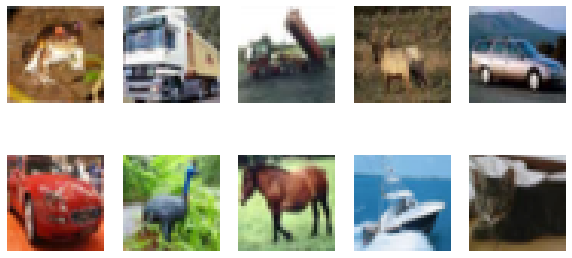

Train dataset batch 개수: 782


In [2]:
#STEP 2. 데이터셋 구성하기
# 데이터 로드 및 필터링 함수
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

    if label is not None:
        # 훈련 데이터 필터링
        train_df = pd.DataFrame({'image': list(train_x), 'label': list(train_y.flatten())})
        train_x = np.array(train_df[train_df['label'] == label]['image'].tolist())

        # 테스트 데이터 필터링
        test_df = pd.DataFrame({'image': list(test_x), 'label': list(test_y.flatten())})
        test_x = np.array(test_df[test_df['label'] == label]['image'].tolist())

    return train_x, test_x

# CIFAR-10 데이터 로드 (전체 데이터)
train_x, test_x = load_data()

# CIFAR-10 경로 출력 (Windows & Linux/macOS 대응)
if os.name == "nt":  # Windows
    dataset_dir = os.path.join(os.environ["USERPROFILE"], ".keras", "datasets")
else:  # Linux/macOS
    dataset_dir = os.path.join(os.path.expanduser("~"), ".keras", "datasets")

print("Dataset directory:", dataset_dir)

# 데이터 정규화: 픽셀 값을 [-1, 1]로 변환
train_x = (train_x / 127.5) - 1
test_x = (test_x / 127.5) - 1

# 데이터 차원 출력
print("Train shape:", train_x.shape)
print("Test shape:", test_x.shape)

# CIFAR-10 이미지 시각화 (10개 샘플)
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow((train_x[i] + 1) / 2)  # 정규화된 이미지를 원래대로 변환하여 표시
    plt.axis('off')
plt.show()

# tf.data.Dataset을 사용하여 미니배치 데이터셋 생성
BATCH_SIZE = 64
BUFFER_SIZE = 50000  # 데이터 섞기 위한 버퍼 크기

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 데이터셋 크기 출력
print(f"Train dataset batch 개수: {len(list(train_dataset))}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0

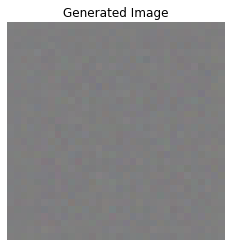

Generated Image Shape: (1, 32, 32, 3)


In [3]:
# STEP 3. 생성자 모델 구현하기
# 생성자 모델 정의
def make_generator_model():
    model = tf.keras.Sequential()

    # Dense 레이어 (입력: 100차원 벡터 → 8x8x256 크기로 변환)
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))  # (8, 8, 256)

    # 첫 번째 Conv2DTranspose (업샘플링: 8x8 → 16x16)
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 두 번째 Conv2DTranspose (업샘플링: 16x16 → 32x32)
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 세 번째 Conv2DTranspose (출력층: 32x32x3, tanh 활성화 함수 사용)
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(1, 1), padding="same", use_bias=False, activation="tanh"))

    return model

# 생성자 모델 생성
generator = make_generator_model()
generator.summary()

# 랜덤 노이즈 생성
noise = tf.random.normal([1, 100])  # 1개 샘플, 100차원 노이즈
generated_image = generator(noise, training=False)  # 생성된 이미지

# 이미지 시각화
plt.imshow((generated_image[0] + 1) / 2)  # [-1,1] → [0,1]로 변환 후 출력
plt.axis("off")
plt.title("Generated Image")
plt.show()

# 생성된 이미지 Shape 확인
print("Generated Image Shape:", generated_image.shape)

In [4]:
#STEP 4: 판별자(Discriminator) 모델 구현
# 판별자(Discriminator) 모델 정의
def make_discriminator_model():
    model = tf.keras.Sequential()

    # 1st Conv Layer: (32, 32, 3) → (16, 16, 64)
    model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding="same", input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU())  # 활성화 함수
    model.add(layers.Dropout(0.3))  # 과적합 방지

    # 2nd Conv Layer: (16, 16, 64) → (8, 8, 128)
    model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 3rd Conv Layer: (8, 8, 128) → (4, 4, 256)
    model.add(layers.Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten & Dense Layer
    model.add(layers.Flatten())  # 4*4*256 → 4096
    model.add(layers.Dense(1))  # 최종 판별값 (스칼라 값)

    return model

# 판별자 모델 생성
discriminator = make_discriminator_model()
discriminator.summary()

# 생성된 이미지 판별
decision = discriminator(generated_image, training=False)
print("Discriminator Output:", decision.numpy())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)        

In [5]:
#STEP 5. 손실함수와 최적화 함수 구현하기
# Binary Cross Entropy 손실 함수
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 생성자 손실 함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # 가짜 이미지를 진짜(1)로 인식하도록 유도

# 판별자 손실 함수
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # 진짜 이미지를 1로 판별
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # 가짜 이미지를 0으로 판별
    total_loss = real_loss + fake_loss
    return total_loss

# 판별자 정확도 계산 함수
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(real_output >= 0, tf.float32))  # 0 이상이면 진짜(1)로 판별
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0, tf.float32))  # 0 미만이면 가짜(0)로 판별
    return real_accuracy, fake_accuracy

# Adam Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# 테스트: 손실 및 정확도 확인
fake_output = tf.constant([[0.00194192]])  # 판별자가 생성된 이미지를 가짜로 판단한 예시값
real_output = tf.constant([[1.5]])  # 진짜 이미지에 대한 판별값

print("Generator Loss:", generator_loss(fake_output).numpy())
print("Discriminator Loss:", discriminator_loss(real_output, fake_output).numpy())

real_acc, fake_acc = discriminator_accuracy(real_output, fake_output)
print(f"Discriminator Accuracy - Real: {real_acc.numpy()}, Fake: {fake_acc.numpy()}")


Generator Loss: 0.6921767
Discriminator Loss: 0.8955319
Discriminator Accuracy - Real: 1.0, Fake: 0.0


In [6]:
#2. generate_and_save_images() - 생성된 이미지 저장
# 이미지 저장 경로 설정
output_dir = "training_checkpoints/generated_images"
os.makedirs(output_dir, exist_ok=True)

def generate_and_save_images(model, epoch, sample_seeds):
    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2)  # [-1, 1] → [0, 1] 변환
        plt.axis("off")

    filename = os.path.join(output_dir, f"epoch_{epoch:04d}.png")
    plt.savefig(filename)
    plt.close()

    print(f"✅ 이미지 저장 완료: {filename}")

#3. draw_train_history() - 손실 및 정확도 그래프
def draw_train_history(history, epoch):
    plt.figure(figsize=(12, 6))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history['gen_loss'], label="Generator Loss")
    plt.plot(history['disc_loss'], label="Discriminator Loss")
    plt.xlabel("Batch Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss")

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history['real_accuracy'], label="Real Accuracy")
    plt.plot(history['fake_accuracy'], label="Fake Accuracy")
    plt.xlabel("Batch Iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Discriminator Accuracy")

    # 그래프 저장
    history_dir = "training_checkpoints/train_history"
    os.makedirs(history_dir, exist_ok=True)
    filename = os.path.join(history_dir, f"train_history_{epoch:04d}.png")
    plt.savefig(filename)
    plt.close()

    print(f"📈 학습 그래프 저장 완료: {filename}")

#4. 체크포인트 저장
checkpoint_dir = "training_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
#STEP 6. 훈련과정 상세 기능 구현하기
#1. train_step() - 1개 미니배치 학습
# ✅ noise_dim 전역 변수 추가 (랜덤 노이즈 차원)
noise_dim = 100
BATCH_SIZE = 64

# 고정된 16개 샘플 노이즈
seed = tf.random.normal([16, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # 100차원 노이즈 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)  # 가짜 이미지 생성

        real_output = discriminator(images, training=True)  # 진짜 이미지 판별
        fake_output = discriminator(generated_images, training=True)  # 가짜 이미지 판별

        gen_loss = generator_loss(fake_output)  # 생성자 손실
        disc_loss = discriminator_loss(real_output, fake_output)  # 판별자 손실

    # Gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimizer 적용
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # 판별자 정확도 계산
    real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

#2. generate_and_save_images() - 생성된 이미지 저장
# 이미지 저장 경로 설정
output_dir = "training_checkpoints/generated_images"
os.makedirs(output_dir, exist_ok=True)

def generate_and_save_images(model, epoch, sample_seeds):
    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2)  # [-1, 1] → [0, 1] 변환
        plt.axis("off")

    filename = os.path.join(output_dir, f"epoch_{epoch:04d}.png")
    plt.savefig(filename)
    plt.close()

    print(f"✅ 이미지 저장 완료: {filename}")

#3. draw_train_history() - 손실 및 정확도 그래프
def draw_train_history(history, epoch):
    plt.figure(figsize=(12, 6))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history['gen_loss'], label="Generator Loss")
    plt.plot(history['disc_loss'], label="Discriminator Loss")
    plt.xlabel("Batch Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss")

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history['real_accuracy'], label="Real Accuracy")
    plt.plot(history['fake_accuracy'], label="Fake Accuracy")
    plt.xlabel("Batch Iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Discriminator Accuracy")

    # 그래프 저장
    history_dir = "training_checkpoints/train_history"
    os.makedirs(history_dir, exist_ok=True)
    filename = os.path.join(history_dir, f"train_history_{epoch:04d}.png")
    plt.savefig(filename)
    plt.close()

    print(f"📈 학습 그래프 저장 완료: {filename}")

#4. 체크포인트 저장
checkpoint_dir = "training_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#5. 실행 코드
# 고정된 16개 샘플 노이즈
seed = tf.random.normal([16, 100])

# 학습 함수
def train(dataset, epochs, save_every=10):
    history = {'gen_loss': [], 'disc_loss': [], 'real_accuracy': [], 'fake_accuracy': []}

    for epoch in range(epochs):
        print(f"📢 Epoch {epoch+1}/{epochs} 시작")
        for image_batch in dataset:
            gen_loss, disc_loss, real_acc, fake_acc = train_step(image_batch)

            # 히스토리 저장
            history['gen_loss'].append(gen_loss.numpy())
            history['disc_loss'].append(disc_loss.numpy())
            history['real_accuracy'].append(real_acc.numpy())
            history['fake_accuracy'].append(fake_acc.numpy())

        # 10 Epoch마다 저장
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # 생성된 이미지 저장
        generate_and_save_images(generator, epoch + 1, seed)

        # 학습 그래프 저장
        draw_train_history(history, epoch + 1)


🚀 학습 시작
📢 Epoch 1/50 시작
✅ 이미지 저장 완료: training_checkpoints/generated_images/epoch_0001.png
📈 학습 그래프 저장 완료: training_checkpoints/train_history/train_history_0001.png
📢 Epoch 2/50 시작
✅ 이미지 저장 완료: training_checkpoints/generated_images/epoch_0002.png
📈 학습 그래프 저장 완료: training_checkpoints/train_history/train_history_0002.png
📢 Epoch 3/50 시작
✅ 이미지 저장 완료: training_checkpoints/generated_images/epoch_0003.png
📈 학습 그래프 저장 완료: training_checkpoints/train_history/train_history_0003.png
📢 Epoch 4/50 시작
✅ 이미지 저장 완료: training_checkpoints/generated_images/epoch_0004.png
📈 학습 그래프 저장 완료: training_checkpoints/train_history/train_history_0004.png
📢 Epoch 5/50 시작
✅ 이미지 저장 완료: training_checkpoints/generated_images/epoch_0005.png
📈 학습 그래프 저장 완료: training_checkpoints/train_history/train_history_0005.png
📢 Epoch 6/50 시작
✅ 이미지 저장 완료: training_checkpoints/generated_images/epoch_0006.png
📈 학습 그래프 저장 완료: training_checkpoints/train_history/train_history_0006.png
📢 Epoch 7/50 시작
✅ 이미지 저장 완료: training_checkpoints/genera

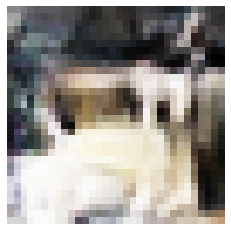

In [ ]:
#STEP7: 학습과정 진행 및 모델 저장 & GIF 생성
#1. 모델 학습 진행
# 학습 실행 (최소 50 Epoch)
EPOCHS = 50  # 최소 50 Epoch 학습

print("🚀 학습 시작")
train(train_dataset, EPOCHS, save_every=10)
print("🎉 학습 완료")

#2. 학습 과정 GIF 생성
import imageio
import glob

# ✅ GIF 파일 저장 함수
def create_gif(image_folder, gif_filename):
    images = []
    file_list = sorted(glob.glob(os.path.join(image_folder, "*.png")))

    for filename in file_list:
        images.append(imageio.imread(filename))

    gif_path = os.path.join(image_folder, gif_filename)
    imageio.mimsave(gif_path, images, duration=0.5)
    print(f"🎞️ GIF 저장 완료: {gif_path}")

# ✅ 학습 중간 생성된 이미지를 이용해 GIF 생성
image_folder = "training_checkpoints/generated_images"
gif_filename = "training_progress.gif"
create_gif(image_folder, gif_filename)

#3. 저장된 모델 로드 & 테스트

# ✅ 체크포인트 로드
checkpoint_dir = "training_checkpoints"
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

# ✅ 모델 불러오기
generator = checkpoint.generator
discriminator = checkpoint.discriminator

# ✅ 모델이 정상적으로 작동하는지 테스트
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# ✅ 정규화 해제 후 출력
np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5  # [-1,1] → [0,255] 변환
np_generated = np_generated.astype(int)

plt.imshow(np_generated[0])
plt.axis("off")
plt.show()


In [ ]:
회고 : 노드에는 에포크가 50으로 되어 있어서 200까지 올려 봤는데 크게 개선되는 효과는 없었습니다.  